In [1]:
import os
import sys
import openai
import pandas as pd
import numpy as np
import argparse
from transformers import BloomTokenizerFast, BloomModel,BloomForCausalLM
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

In [2]:
mapping={
'No Poverty':'01.No Poverty',
'Zero Hunger':'02.Zero Hunger',
'Good Health and Well-Being':'03.Good Health and Well-Being',
'Quality Education':'04.Quality Education',
'Gender Equality':'05.Gender Equality',
'Clean Water and Sanitation':'06.Clean Water and Sanitation',
'Affordable and Clean Energy':'07.Affordable and Clean Energy',
'Decent Work and Economic Growth':'08.Decent Work and Economic Growth',
'Industry, Innovation and Infrastructure':'09.Industry, Innovation and Infrastructure',
'Reduced Inequalities':'10.Reduced Inequalities',
'Sustainable Cities and Communities':'11.Sustainable Cities and Communities',
'Responsible Consumption and Production':'12.Responsible Consumption and Production',
'Climate Action':'13.Climate Action',
'Life Below Water':'14.Life Below Water',
'Life on Land':'15.Life on Land',
'Peace, Justice and Strong Institutions':'16.Peace, Justice and Strong Institutions',
'Partnership for the Goals':'17.Partnership for the Goals',
    'Partnership for the goals':'17.Partnership for the Goals',
}

goal_list=[
'01.No Poverty',
'02.Zero Hunger',
'03.Good Health and Well-Being',
'04.Quality Education',
'05.Gender Equality',
'06.Clean Water and Sanitation',
'07.Affordable and Clean Energy',
'08.Decent Work and Economic Growth',
'09.Industry, Innovation and Infrastructure',
'10.Reduced Inequalities',
'11.Sustainable Cities and Communities',
'12.Responsible Consumption and Production',
'13.Climate Action',
'14.Life Below Water',
'15.Life on Land',
'16.Peace, Justice and Strong Institutions',
'17.Partnership for the Goals'
    ]

In [3]:
def get_sn_rules_classification(df_classification):
    sd_pivot=pd.melt(df_classification,id_vars=['ID'],
            value_vars=['Reduced Inequalities', 'Sustainable Cities and Communities',
           'Responsible Consumption and Production', 'Good Health and Well-Being',
           'Life on Land', 'Life Below Water',
           'Peace, Justice and Strong Institutions',
           'Decent Work and Economic Growth', 'Partnership for the Goals',
           'Affordable and Clean Energy', 'Clean Water and Sanitation',
           'Industry, Innovation and Infrastructure', 'Quality Education',
           'Gender Equality', 'No Poverty', 'Climate Action', 'No Hunger',
            'Disinformation and fake news', 'Privacy protection', 'Deception detection','Hate speech'],value_name='proba',var_name="social_need")

    sd_pivot=sd_pivot.sort_values('proba',ascending=False)
    sd_pivot=sd_pivot.groupby(['ID']).head(2)
    sd_pivot=sd_pivot.assign(place=sd_pivot.groupby(['ID']).cumcount())
    sd_pivot=sd_pivot.fillna("")
    sn_top2=pd.pivot_table(sd_pivot,index=['ID'],columns=['place'],values=['social_need'],
                  aggfunc=np.sum)
    sn_top2=sn_top2.reset_index()
    sn_top2.columns=[col[0]+""+str(col[1]) for col in sn_top2.columns]
    sd_pivot_max=sd_pivot.groupby(['ID']).proba.max().reset_index().rename(columns={'proba':'proba_max'})
    df_classification=df_classification.merge(sn_top2,on=['ID'],how='left').merge(sd_pivot_max,on=['ID'])

    df_sn=df_classification.loc[:,['ID','social_need0','social_need1',"proba_max"]]
    return df_sn

In [4]:
def get_sn_rules_classification_normal(df_classification):
    sd_pivot=pd.melt(df_classification,id_vars=['ID'],
            value_vars=['Reduced Inequalities', 'Sustainable Cities and Communities',
           'Responsible Consumption and Production', 'Good Health and Well-Being',
           'Life on Land', 'Life Below Water',
           'Peace, Justice and Strong Institutions',
           'Decent Work and Economic Growth', 'Partnership for the Goals',
           'Affordable and Clean Energy', 'Clean Water and Sanitation',
           'Industry, Innovation and Infrastructure', 'Quality Education',
           'Gender Equality', 'No Poverty', 'Climate Action', 'No Hunger'],value_name='proba',var_name="social_need")

    sd_pivot=sd_pivot.sort_values('proba',ascending=False)
    sd_pivot=sd_pivot.groupby(['ID']).head(2)
    sd_pivot=sd_pivot.assign(place=sd_pivot.groupby(['ID']).cumcount())
    sd_pivot=sd_pivot.fillna("")
    sn_top2=pd.pivot_table(sd_pivot,index=['ID'],columns=['place'],values=['social_need'],
                  aggfunc=np.sum)
    sn_top2=sn_top2.reset_index()
    sn_top2.columns=[col[0]+""+str(col[1]) for col in sn_top2.columns]
    sd_pivot_max=sd_pivot.groupby(['ID']).proba.max().reset_index().rename(columns={'proba':'proba_max'})
    df_classification=df_classification.merge(sn_top2,on=['ID'],how='left').merge(sd_pivot_max,on=['ID'])

    df_sn=df_classification.loc[:,['ID','social_need0','social_need1',"proba_max"]]
    return df_sn

In [5]:
def get_gold_and_predicted(df):
    prediction=[]
    for i,d in df.iterrows():
        pred=[]
        if d['sdg1']==1:
            pred.append(goal_list[0])
        if d['sdg2']==1:
            pred.append(goal_list[1])
        if d['sdg3']==1:
            pred.append(goal_list[2])
        if d['sdg4']==1:
            pred.append(goal_list[3])
        if d['sdg5']==1:
            pred.append(goal_list[4])
        if d['sdg6']==1:
            pred.append(goal_list[5])
        if d['sdg7']==1:
            pred.append(goal_list[6])
        if d['sdg8']==1:
            pred.append(goal_list[7])
        if d['sdg9']==1:
            pred.append(goal_list[8])
        if d['sdg10']==1:
            pred.append(goal_list[9])
        if d['sdg11']==1:
            pred.append(goal_list[10])
        if d['sdg12']==1:
            pred.append(goal_list[11])
        if d['sdg13']==1:
            pred.append(goal_list[12])
        if d['sdg14']==1:
            pred.append(goal_list[13])
        if d['sdg15']==1:
            pred.append(goal_list[14])
        if d['sdg16']==1:
            pred.append(goal_list[15])
        if d['sdg17']==1:
            pred.append(goal_list[16])
        prediction.append(pred)

    actual=[]
    for i,d in df.iterrows():
        act=[d['Goal1_numeric']]
        if d['Goal2_filled']!='':
            act.append(d['Goal2_filled'])
        if d['Goal3_filled']!='':
            act.append(d['Goal3_filled'])
        actual.append(act)
        
    return actual,prediction

In [6]:
def format_gold(df):
    df['Goal1_numeric']=df.goal1.replace(mapping)
    df['Goal2_numeric']=df.goal2.replace(mapping)
    df['Goal3_numeric']=df.goal3.replace(mapping)
    df['Goal2_filled']=df.Goal2_numeric.fillna('')
    df['Goal3_filled']=df.Goal3_numeric.fillna('')
    return df

In [7]:
def extract_predictions_gpt3(df):
    df=df.assign(sdg1=np.where(df['GPT3_response'].str.lower().str.contains("goal 1 |goal 1:|poverty"),1,0))
    df=df.assign(sdg2=np.where(df['GPT3_response'].str.lower().str.contains("goal 2|hunger"),1,0))
    df=df.assign(sdg3=np.where(df['GPT3_response'].str.lower().str.contains("goal 3|health"),1,0))
    df=df.assign(sdg4=np.where(df['GPT3_response'].str.lower().str.contains("goal 4|education"),1,0))
    df=df.assign(sdg5=np.where(df['GPT3_response'].str.lower().str.contains("goal 5|gender"),1,0))
    df=df.assign(sdg6=np.where(df['GPT3_response'].str.lower().str.contains("goal 6|clean water"),1,0))
    df=df.assign(sdg7=np.where(df['GPT3_response'].str.lower().str.contains("goal 7|clean energy"),1,0))
    df=df.assign(sdg8=np.where(df['GPT3_response'].str.lower().str.contains("goal 8|decent work"),1,0))
    df=df.assign(sdg9=np.where(df['GPT3_response'].str.lower().str.contains("goal 9|industry|innovation"),1,0))
    df=df.assign(sdg10=np.where(df['GPT3_response'].str.lower().str.contains("goal 10|inequal"),1,0))
    df=df.assign(sdg11=np.where(df['GPT3_response'].str.lower().str.contains("goal 11|sustainable cities"),1,0))
    df=df.assign(sdg12=np.where(df['GPT3_response'].str.lower().str.contains("goal 12|responsible consumption"),1,0))
    df=df.assign(sdg13=np.where(df['GPT3_response'].str.lower().str.contains("goal 13|climate"),1,0))
    df=df.assign(sdg14=np.where(df['GPT3_response'].str.lower().str.contains("goal 14|life below water"),1,0))
    df=df.assign(sdg15=np.where(df['GPT3_response'].str.lower().str.contains("goal 15|life on land"),1,0))
    df=df.assign(sdg16=np.where(df['GPT3_response'].str.lower().str.contains("goal 16|peace|justice"),1,0))
    df=df.assign(sdg17=np.where(df['GPT3_response'].str.lower().str.contains("goal 17|partnership"),1,0))
    return df

def extract_predictions_mnli(df):
    mapping_mnli={
    'No Poverty':'sdg1',
    'Zero Hunger':'sdg2',
    'Good Health and Well-Being':'sdg3',
    'Quality Education':'sdg4',
    'Gender Equality':'sdg5',
    'Clean Water and Sanitation':'sdg6',
    'Affordable and Clean Energy':'sdg7',
    'Decent Work and Economic Growth':'sdg8',
    'Industry, Innovation and Infrastructure':'sdg9',
    'Reduced Inequalities':'sdg10',
    'Sustainable Cities and Communities':'sdg11',
    'Responsible Consumption and Production':'sdg12',
    'Climate Action':'sdg13',
    'Life Below Water':'sdg14',
    'Life on Land':'sdg15',
    'Hate speech':'sdg16',
    'Disinformation and fake news':'sdg16',
    'Deception detection':'sdg16',
    'Privacy protection':'sdg16',
    'Peace, Justice and Strong Institutions':'sdg16',
    'Partnership for the Goals':'sdg17',
    }


    
    df=df.assign(sdg1=np.where(df['No Poverty']>=0.5,1,0))
    df=df.assign(sdg2=np.where(df['No Hunger']>=0.5,1,0))
    df=df.assign(sdg3=np.where(df['Good Health and Well-Being']>=0.5,1,0))
    df=df.assign(sdg4=np.where(df['Quality Education']>=0.5,1,0))
    df=df.assign(sdg5=np.where(df['Gender Equality']>=0.5,1,0))
    df=df.assign(sdg6=np.where(df['Clean Water and Sanitation']>=0.5,1,0))
    df=df.assign(sdg7=np.where(df['Affordable and Clean Energy']>=0.5,1,0))
    df=df.assign(sdg8=np.where(df['Decent Work and Economic Growth']>=0.5,1,0))
    df=df.assign(sdg9=np.where(df['Industry, Innovation and Infrastructure']>=0.5,1,0))
    df=df.assign(sdg10=np.where(df['Reduced Inequalities']>=0.5,1,0))
    df=df.assign(sdg11=np.where(df['Sustainable Cities and Communities']>=0.5,1,0))
    df=df.assign(sdg12=np.where(df['Responsible Consumption and Production']>=0.5,1,0))
    df=df.assign(sdg13=np.where(df['Climate Action']>=0.5,1,0))
    df=df.assign(sdg14=np.where(df['Life Below Water']>=0.5,1,0))
    df=df.assign(sdg15=np.where(df['Life on Land']>=0.5,1,0))
    df=df.assign(sdg16=np.where(df['Peace, Justice and Strong Institutions']>=0.5,1,0))
    df=df.assign(sdg16=np.where(df['Privacy protection']>=0.5,1,df.sdg16))
    df=df.assign(sdg16=np.where(df['Deception detection']>=0.5,1,df.sdg16))
    df=df.assign(sdg16=np.where(df['Hate speech']>=0.5,1,df.sdg16))
    df=df.assign(sdg16=np.where(df['Disinformation and fake news']>=0.5,1,df.sdg16))
    df=df.assign(sdg17=np.where(df['Partnership for the Goals']>=0.5,1,0))

    df_top=get_sn_rules_classification(df)
    df_top=get_sn_rules_classification_normal(df)
    df=df.merge(df_top,on=['ID'],how='left')
    for i,d in df.iterrows():
        df.at[i,mapping_mnli[d['social_need0']]]=1
    return df

In [8]:
data_path="../data/"
outputs_path="../outputs/"
#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_all_singularq_f2.csv")

#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_all_singular_plural_f.csv")

#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_all_singular_plural_contribute.csv")
#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_all_plural_contribute.csv")
#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_all_plural_contribute_explanation.csv")
#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_all_singular_ff.csv")
#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_all_plural_ff.csv")

gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_un_singular_ff.csv")

#gpt3_goals=pd.read_csv("../../../nlp4sg_research_tracking/sg_match/gpt3_un_plural_ff.csv")
mnli_classifier=pd.read_csv(outputs_path+"sg_goals/goal_classifier_test_desc.csv")

In [9]:
test_set_complete=pd.read_csv(outputs_path+"general/test_set_final.csv")
train_set=pd.read_csv(outputs_path+"general/train_set_final.csv")
dev_set=pd.read_csv(outputs_path+"general/dev_set_final.csv")
test_set=test_set_complete.iloc[:2000]
low_ocurrence=pd.read_csv(data_path+"test_data/low_occurrence.csv")
low_ocurrence=low_ocurrence.rename(columns={'Most Related SG goal':'goal1_raw',
       '(if exists) 2nd Related SG Goal':'goal2_raw', '(if exists) 3rd Related SG Goal':'goal3_raw'})
low_ocurrence=low_ocurrence.rename(columns={"Zhijing's annotation of SG_or_not":"label"})
low_ocurrence["label"]=low_ocurrence["label"].fillna(0)
low_ocurrence=low_ocurrence.iloc[:97]
df_all_goals=pd.concat([dev_set,train_set,test_set,low_ocurrence])
df_all_goals=df_all_goals.loc[df_all_goals.label==1]

In [10]:
gpt3_goals=gpt3_goals.loc[gpt3_goals.ID.isin(df_all_goals.ID.unique())]
gpt3_goals=gpt3_goals.loc[:,['ID', 'url', 'label', 'task_annotation', 'method_annotation',
       'org_annotation', 'goal1_raw', 'goal2_raw', 'goal3_raw',
       'title_abstract_clean', 'title', 'abstract', 'title_clean',
       'abstract_clean', 'acknowledgments_clean', 'text', 'year', 'Goal',
       'goal1', 'goal2', 'goal3', 'statement','full_prompt', 'GPT3_response']]
gpt3_goals.shape

(720, 24)

In [11]:
gpt3_goals=format_gold(gpt3_goals)

df=gpt3_goals.copy()
df=extract_predictions_gpt3(df)

mnli_classifier=mnli_classifier.loc[mnli_classifier.ID.isin(df_all_goals.ID.unique())]
mnli_classifier=format_gold(mnli_classifier)

df=mnli_classifier.copy()
df=extract_predictions_mnli(df)

In [12]:
df.loc[df.sdg3==1].shape

(208, 46)

In [13]:
df=df.assign(goal2=np.where(df.goal1==df.goal2,'',df.goal2))
df=df.assign(goal3=np.where(df.goal2==df.goal3,'',df.goal3))

In [14]:
df.loc[df.goal1!=''].shape

(720, 46)

In [15]:
df.loc[(~df.goal2.isna())& (df.goal2!='')].shape

(101, 46)

In [16]:
df.loc[~df.goal3.isna()& (df.goal3!='')].shape

(6, 46)

In [17]:
df.loc[df.goal2==df.goal3]

,ID,url,label,task_annotation,method_annotation,org_annotation,goal1_raw,goal2_raw,goal3_raw,title_abstract_clean,title,abstract,title_clean,abstract_clean,acknowledgments_clean,text,year,Goal,goal1,goal2,goal3,statement,full_prompt,GPT3_response,Goal1_numeric,Goal2_numeric,Goal3_numeric,Goal2_filled,Goal3_filled,sdg1,sdg2,sdg3,sdg4,sdg5,sdg6,sdg7,sdg8,sdg9,sdg10,sdg11,sdg12,sdg13,sdg14,sdg15,sdg16,sdg17


df.sdg1.sum()+df.sdg2.sum()+df.sdg3.sum()+df.sdg4.sum()+df.sdg5.sum()+df.sdg6.sum()+df.sdg7.sum()+df.sdg8.sum()+df.sdg9.sum()+df.sdg10.sum()
+df.sdg11.sum()+df.sdg12.sum()+df.sdg13.sum()+df.sdg14.sum()+df.sdg15.sum()+df.sdg16.sum()+df.sdg17.sum()

In [18]:
df.loc[df.sdg1+df.sdg2+df.sdg3+df.sdg4+df.sdg5+df.sdg6+df.sdg7+df.sdg8+df.sdg9+df.sdg10+
      df.sdg11+df.sdg12+df.sdg13+df.sdg14+df.sdg15+df.sdg16+df.sdg17>1]

,ID,url,label,task_annotation,method_annotation,org_annotation,goal1_raw,goal2_raw,goal3_raw,title_abstract_clean,title,abstract,title_clean,abstract_clean,acknowledgments_clean,text,year,Goal,goal1,goal2,goal3,statement,full_prompt,GPT3_response,Goal1_numeric,Goal2_numeric,Goal3_numeric,Goal2_filled,Goal3_filled,sdg1,sdg2,sdg3,sdg4,sdg5,sdg6,sdg7,sdg8,sdg9,sdg10,sdg11,sdg12,sdg13,sdg14,sdg15,sdg16,sdg17


In [19]:
df.loc[df.sdg1+df.sdg2+df.sdg3+df.sdg4+df.sdg5+df.sdg6+df.sdg7+df.sdg8+df.sdg9+df.sdg10+
      df.sdg11+df.sdg12+df.sdg13+df.sdg14+df.sdg15+df.sdg16+df.sdg17==0].GPT3_response.values

array(['\n\nThis paper does not contribute directly to any of the UN goals.',
       '\n\nThe paper does not contribute to any specific UN goal.',
       '\n\nThe paper does not contribute to any specific UN goal, but could be said to contribute to the goal of improving communication between people of different cultures.',
       '\n\nThis paper does not contribute to any of the UN goals.',
       '\n\nThis paper does not contribute to any of the UN goals.',
       '\n\nThis paper contributes to the UN goal of reducing exposure to misinformation on social media.',
       '\n\nThis paper does not contribute to any of the UN goals.',
       '\n\nThis paper does not contribute to any specific UN goal, but it does highlight the limitations of AI in event data collection, which is an important issue to consider when using AI for conflict analysis.',
       '\n\nThis paper does not contribute to any of the UN goals.',
       '\n\nThis paper does not contribute to any of the UN goals.'],
    

In [20]:
gold_labels,prediction=get_gold_and_predicted(df)

In [21]:
len(prediction)

720

In [22]:
total=[['01.No Poverty'],
['02.Zero Hunger'],
['03.Good Health and Well-Being'],
['04.Quality Education'],
['05.Gender Equality'],
['06.Clean Water and Sanitation'],
['07.Affordable and Clean Energy'],
['08.Decent Work and Economic Growth'],
['09.Industry, Innovation and Infrastructure'],
['10.Reduced Inequalities'],
['11.Sustainable Cities and Communities'],
['12.Responsible Consumption and Production'],
['13.Climate Action'],
['14.Life Below Water'],
['15.Life on Land'],
['16.Peace, Justice and Strong Institutions'],
['17.Partnership for the Goals']]


mlb = MultiLabelBinarizer()

mlb.fit(total)

MultiLabelBinarizer()

In [23]:
mlb.classes_

array(['01.No Poverty', '02.Zero Hunger', '03.Good Health and Well-Being',
       '04.Quality Education', '05.Gender Equality',
       '06.Clean Water and Sanitation', '07.Affordable and Clean Energy',
       '08.Decent Work and Economic Growth',
       '09.Industry, Innovation and Infrastructure',
       '10.Reduced Inequalities', '11.Sustainable Cities and Communities',
       '12.Responsible Consumption and Production', '13.Climate Action',
       '14.Life Below Water', '15.Life on Land',
       '16.Peace, Justice and Strong Institutions',
       '17.Partnership for the Goals'], dtype=object)

In [24]:
gold = mlb.transform(gold_labels)

pred = mlb.transform(prediction)

cm = skm.multilabel_confusion_matrix(gold, pred)

In [25]:
for a,b,c,d in zip(gold,pred,gold_labels,prediction):
    print(a,c)
    print(b,d)
    print("##########")

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1] ['08.Decent Work and Economic Growth', '17.Partnership for the Goals', '16.Peace, Justice and Strong Institutions']
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] ['04.Quality Education']
##########
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] ['16.Peace, Justice and Strong Institutions']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] ['16.Peace, Justice and Strong Institutions']
##########
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ['03.Good Health and Well-Being']
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ['03.Good Health and Well-Being']
##########
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] ['04.Quality Education']
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] ['04.Quality Education']
##########
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ['03.Good Health and Well-Being']
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ['03.Good Health and Well-Being']
##########
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ['03.Good Health and Well-Being']
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ['03.Good Health and Well-Being']
##########
[0 0 0 1 0 0 0 

In [31]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=26):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    sns.set(font_scale=2.4)
    try:
        heatmap = sns.heatmap(df_cm,square=True, annot=True, fmt="d", cmap="Blues",cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    axes.set_title(class_label)

In [27]:
goal_list_names=[
'G1. Poverty',
'G2. Hunger',
'G3. Health',
'G4. Education',
'G5. Gender',
'G6. Water',
'G7. Energy',
'G8. Economy',
'G9. Innovation',
'G10. Inequalities',
'G11. Sustainable Cities',
'G12. Consumption',
'G13. Climate',
'G14. Life Below Water',
'G15. Life on Land',
'G16. Peace',
'G17. Partnership'
    ]

In [37]:
cm2=[cm[2],cm[3],cm[8],cm[15]]

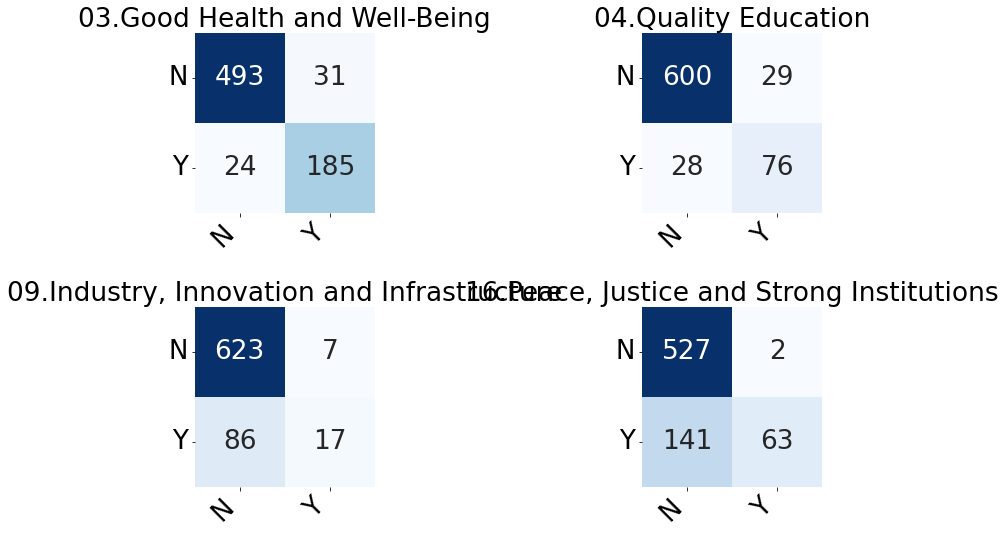

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for axes, cfs_matrix, label in zip(ax.flatten(), cm2, ['03.Good Health and Well-Being','04.Quality Education','09.Industry, Innovation and Infrastructure','16.Peace, Justice and Strong Institutions']):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [46]:
def print_confusion_matrix2(confusion_matrix, axes, class_label, class_names, fontsize=15):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    sns.set(font_scale=1.3)
    try:
        heatmap = sns.heatmap(df_cm,square=True, annot=True, fmt="d", cmap="Blues",cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    axes.set_title(class_label)

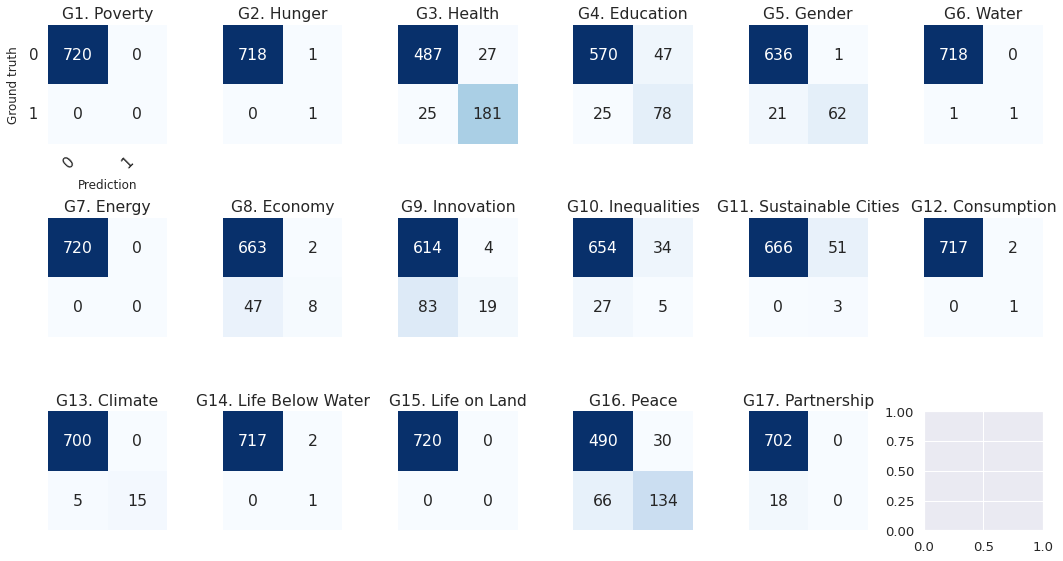

In [47]:
## singular
fig, ax = plt.subplots(3, 6,figsize=(15, 8))
c=0
for axes, cfs_matrix, label in zip(ax.flatten(), cm, goal_list_names):
    if c==0:
        print_confusion_matrix2(cfs_matrix, axes, label, ["0", " 1"])
        axes.set_xlabel('Prediction',size=12)
        axes.set_ylabel('Ground truth',size=12)
    else:
        print_confusion_matrix2(cfs_matrix, axes, label, ["", " "])
    c+=1

#fig.subplots_adjust(wspace=0.1, hspace=0.4)
#axes.set_xlabel('Prediction',size=20)
#fig.text(0.01, 0.5, 'Ground truth', va='center', rotation='vertical')
#fig.text(0.5, 0, 'Prediction', ha='center')
fig.tight_layout()
plt.show()


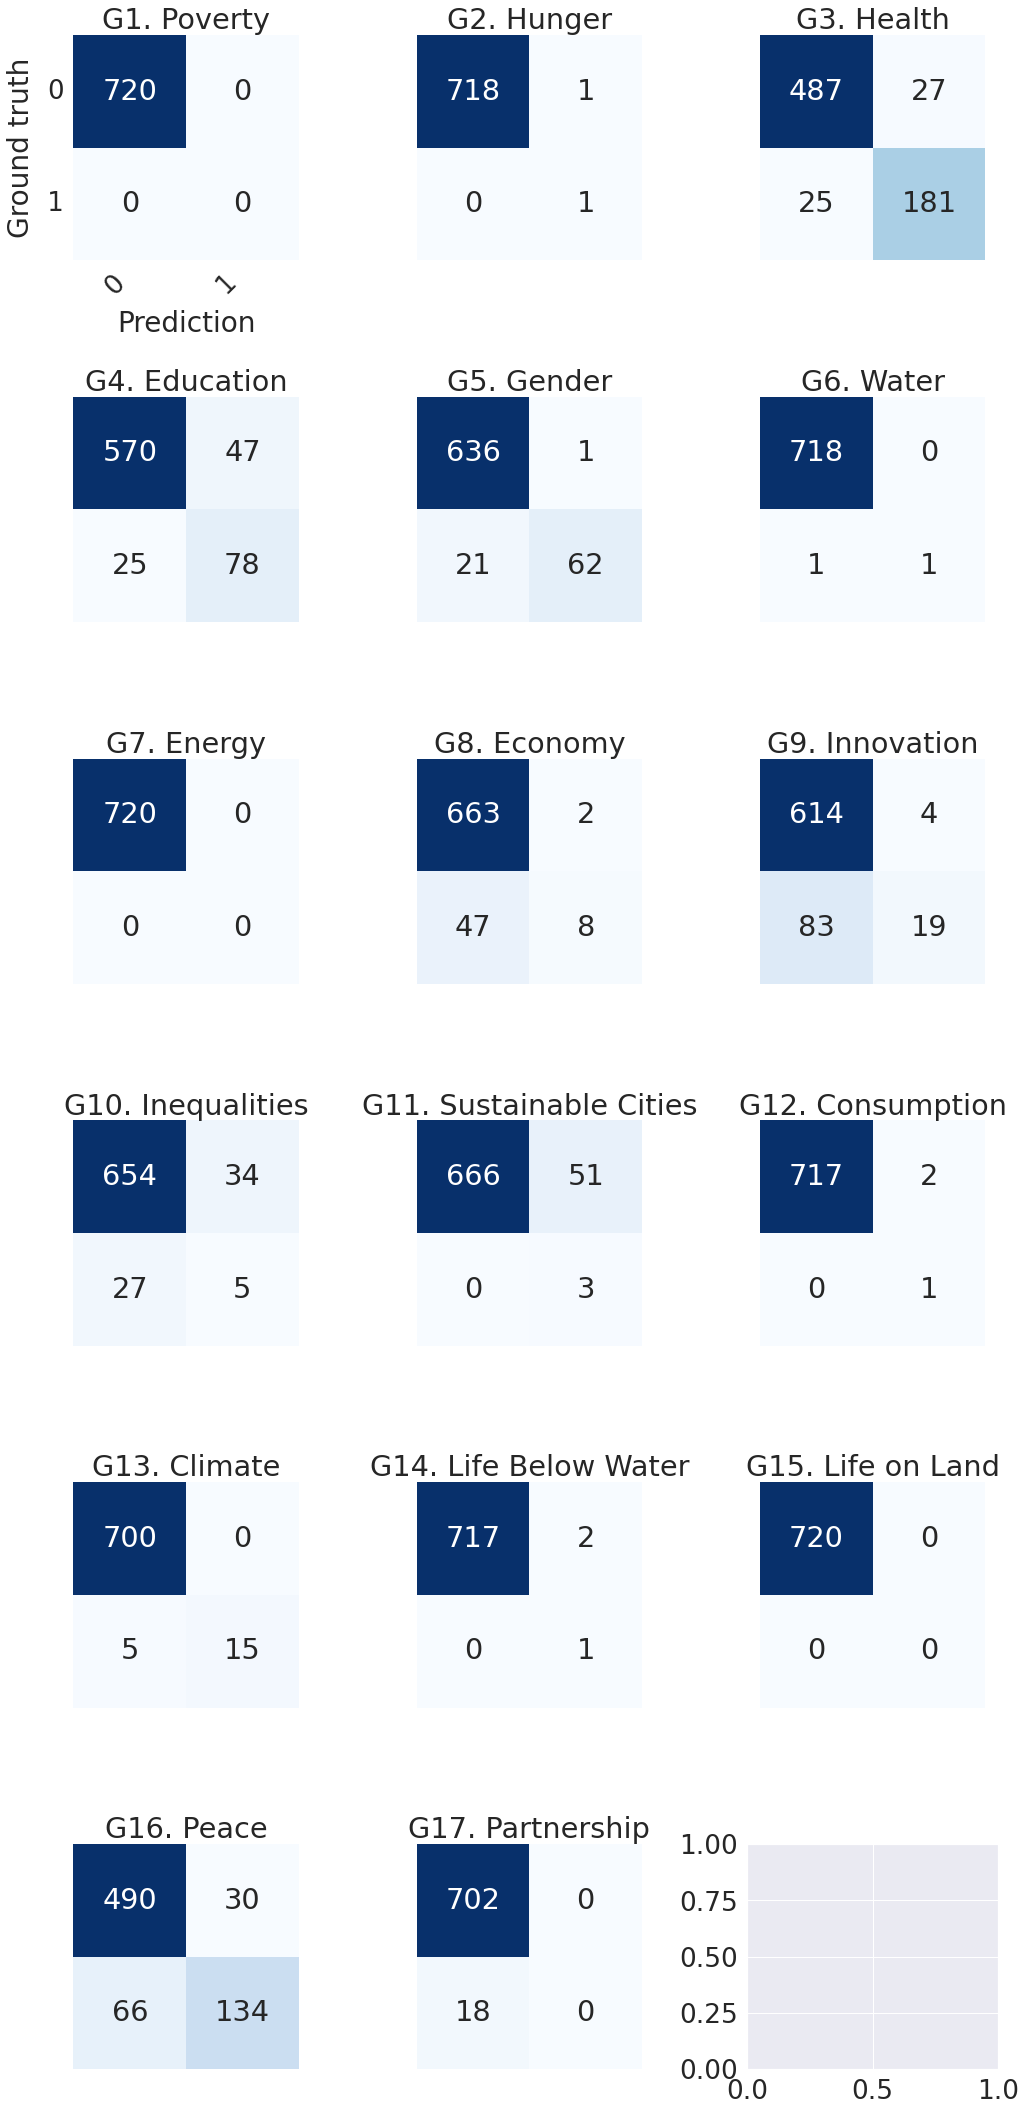

In [33]:
## singular
fig, ax = plt.subplots(6, 3,figsize=(15, 30))
c=0
for axes, cfs_matrix, label in zip(ax.flatten(), cm, goal_list_names):
    if c==0:
        print_confusion_matrix(cfs_matrix, axes, label, ["0", " 1"])
        axes.set_xlabel('Prediction',size=22)
        axes.set_ylabel('Ground truth',size=22)
    else:
        print_confusion_matrix(cfs_matrix, axes, label, ["", " "])
    c+=1

#fig.subplots_adjust(wspace=0.1, hspace=0.4)
#axes.set_xlabel('Prediction',size=20)
#fig.text(0.01, 0.5, 'Ground truth', va='center', rotation='vertical')
#fig.text(0.5, 0, 'Prediction', ha='center')
fig.tight_layout()
plt.show()


In [36]:
partial=0
total=0
for g,p in zip(gold_labels,prediction):
    matches = set(g).intersection(set(p))
    lm=len(matches)
    lt=(len(set(g))+len(set(p)))/2
    if lm>=1:
        partial+=1
    if lm==lt:
        total+=1

In [37]:
## un plural
print("Partial: ",partial/len(prediction))
print("Total: ",total/len(prediction))
print(classification_report(gold, pred,digits=4))

Partial:  0.675
Total:  0.39861111111111114
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0196    1.0000    0.0385         1
           2     0.6828    0.8883    0.7722       206
           3     0.4180    0.7670    0.5411       103
           4     0.5659    0.8795    0.6887        83
           5     0.0909    1.0000    0.1667         2
           6     0.0000    0.0000    0.0000         0
           7     0.2603    0.3455    0.2969        55
           8     0.4590    0.2745    0.3436       102
           9     0.0678    0.2500    0.1067        32
          10     0.0312    1.0000    0.0606         3
          11     0.0000    0.0000    0.0000         1
          12     0.4146    0.8500    0.5574        20
          13     0.2000    1.0000    0.3333         1
          14     0.0000    0.0000    0.0000         0
          15     0.7339    0.4550    0.5617       200
          16     0.0000    0.0000    

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
## un singular
print("Partial: ",partial/len(prediction))
print("Total: ",total/len(prediction))
print(classification_report(gold, pred,digits=4))

Partial:  0.7069444444444445
Total:  0.6208333333333333
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.5000    1.0000    0.6667         1
           2     0.8702    0.8786    0.8744       206
           3     0.6240    0.7573    0.6842       103
           4     0.9841    0.7470    0.8493        83
           5     1.0000    0.5000    0.6667         2
           6     0.0000    0.0000    0.0000         0
           7     0.8000    0.1455    0.2462        55
           8     0.8261    0.1863    0.3040       102
           9     0.1282    0.1562    0.1408        32
          10     0.0556    1.0000    0.1053         3
          11     0.3333    1.0000    0.5000         1
          12     1.0000    0.7500    0.8571        20
          13     0.3333    1.0000    0.5000         1
          14     0.0000    0.0000    0.0000         0
          15     0.8171    0.6700    0.7363       200
          16     0.0000  

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [52]:
## mnli
print("Partial: ",partial/len(prediction))
print("Total: ",total/len(prediction))
print(classification_report(gold, pred,digits=4))

Partial:  0.39444444444444443
Total:  0.10694444444444444
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000         1
           2     0.5714    0.0777    0.1368       206
           3     0.5268    0.5728    0.5488       103
           4     1.0000    0.0361    0.0698        83
           5     1.0000    1.0000    1.0000         2
           6     0.0000    0.0000    0.0000         0
           7     0.2143    0.0545    0.0870        55
           8     0.1468    0.6863    0.2418       102
           9     0.0622    0.4062    0.1079        32
          10     0.0625    0.3333    0.1053         3
          11     0.0769    1.0000    0.1429         1
          12     0.4848    0.8000    0.6038        20
          13     0.0000    0.0000    0.0000         1
          14     0.0000    0.0000    0.0000         0
          15     0.4167    0.5500    0.4741       200
          16     0.1053

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
metrics=pd.DataFrame(classification_report(gold, pred,digits=4,output_dict=True))

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
round(100*(metrics/827),2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,micro avg,macro avg,weighted avg,samples avg
precision,0.0,0.00,0.07,0.06,0.12,0.12,0.0,0.03,0.02,0.01,0.01,0.01,0.06,0.00,0.0,0.05,0.01,0.03,0.03,0.06,0.03
recall,0.0,0.00,0.01,0.07,0.00,0.12,0.0,0.01,0.08,0.05,0.04,0.12,0.10,0.00,0.0,0.07,0.01,0.04,0.04,0.04,0.04
f1-score,0.0,0.00,0.02,0.07,0.01,0.12,0.0,0.01,0.03,0.01,0.01,0.02,0.07,0.00,0.0,0.06,0.01,0.03,0.03,0.03,0.03
support,0.0,0.12,24.91,12.45,10.04,0.24,0.0,6.65,12.33,3.87,0.36,0.12,2.42,0.12,0.0,24.18,2.18,100.00,100.00,100.00,100.00


In [37]:
## singular
print("Partial: ",partial/len(prediction))
print("Total: ",total/len(prediction))
print(classification_report(gold, pred,digits=4))

Partial:  0.6291666666666667
Total:  0.5472222222222223
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000         1
           2     0.9010    0.8398    0.8693       206
           3     0.7551    0.7184    0.7363       103
           4     0.9867    0.8916    0.9367        83
           5     1.0000    1.0000    1.0000         2
           6     0.0000    0.0000    0.0000         0
           7     0.8824    0.2727    0.4167        55
           8     0.8333    0.1961    0.3175       102
           9     0.3333    0.1250    0.1818        32
          10     0.0152    1.0000    0.0299         3
          11     0.3333    1.0000    0.5000         1
          12     1.0000    0.8000    0.8889        20
          13     0.5000    1.0000    0.6667         1
          14     0.0000    0.0000    0.0000         0
          15     0.9333    0.3500    0.5091       200
          16     0.0000  

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [36]:
## plural
print("Partial: ",partial/len(prediction))
print("Total: ",total/len(prediction))
print(classification_report(gold, pred,digits=4))

Partial:  0.6888888888888889
Total:  0.34305555555555556
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.1000    1.0000    0.1818         1
           2     0.7581    0.9126    0.8282       206
           3     0.4570    0.8252    0.5882       103
           4     0.6364    0.9277    0.7549        83
           5     0.2500    1.0000    0.4000         2
           6     0.0000    0.0000    0.0000         0
           7     0.2500    0.3636    0.2963        55
           8     0.4203    0.2843    0.3392       102
           9     0.0667    0.2188    0.1022        32
          10     0.0152    1.0000    0.0299         3
          11     0.0000    0.0000    0.0000         1
          12     0.6400    0.8000    0.7111        20
          13     0.2500    1.0000    0.4000         1
          14     0.0000    0.0000    0.0000         0
          15     0.8636    0.3800    0.5278       200
          16     0.0000 

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
## singular plural contribute
print(classification_report(gold, pred,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000         1
           2     0.8708    0.8835    0.8771       206
           3     0.6783    0.7573    0.7156       103
           4     0.9241    0.8795    0.9012        83
           5     1.0000    1.0000    1.0000         2
           6     0.0000    0.0000    0.0000         0
           7     0.7308    0.3455    0.4691        55
           8     0.7391    0.1667    0.2720       102
           9     0.2258    0.2188    0.2222        32
          10     0.0185    1.0000    0.0364         3
          11     1.0000    1.0000    1.0000         1
          12     0.9444    0.8500    0.8947        20
          13     0.3333    1.0000    0.5000         1
          14     0.0000    0.0000    0.0000         0
          15     0.9412    0.3200    0.4776       200
          16     0.0000    0.0000    0.0000        18

   micro avg     0.6270   

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [20]:
## singular plural
print(classification_report(gold, pred,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000         1
           2     0.8545    0.8835    0.8687       206
           3     0.7282    0.7282    0.7282       103
           4     0.9737    0.8916    0.9308        83
           5     1.0000    1.0000    1.0000         2
           6     0.0000    0.0000    0.0000         0
           7     0.8000    0.2909    0.4267        55
           8     0.7391    0.1667    0.2720       102
           9     0.2353    0.1250    0.1633        32
          10     0.0160    1.0000    0.0314         3
          11     0.0000    0.0000    0.0000         1
          12     1.0000    0.8500    0.9189        20
          13     0.3333    1.0000    0.5000         1
          14     0.0000    0.0000    0.0000         0
          15     0.9688    0.3100    0.4697       200
          16     0.0000    0.0000    0.0000        18

   micro avg     0.6223   

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [23]:
## plural contribute
print(classification_report(gold, pred,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0286    1.0000    0.0556         1
           2     0.6117    0.9175    0.7340       206
           3     0.2784    0.9029    0.4256       103
           4     0.3320    0.9639    0.4938        83
           5     0.0526    1.0000    0.1000         2
           6     0.0000    0.0000    0.0000         0
           7     0.1739    0.5818    0.2678        55
           8     0.2824    0.4706    0.3529       102
           9     0.0550    0.3750    0.0960        32
          10     0.0092    0.6667    0.0181         3
          11     0.0000    0.0000    0.0000         1
          12     0.1839    0.8000    0.2991        20
          13     0.0500    1.0000    0.0952         1
          14     0.0000    0.0000    0.0000         0
          15     0.7143    0.3750    0.4918       200
          16     0.0000    0.0000    0.0000        18

   micro avg     0.2583   

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
## Which of the UN Sustainable Development Goals does this paper contribute to? Provide the goal names, numbers and a explanation.
print(classification_report(gold, pred,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000         1
           2     0.5714    0.0766    0.1350       209
           3     0.5130    0.5673    0.5388       104
           4     1.0000    0.0361    0.0698        83
           5     1.0000    1.0000    1.0000         2
           6     0.0000    0.0000    0.0000         0
           7     0.2143    0.0517    0.0833        58
           8     0.1464    0.6893    0.2415       103
           9     0.0610    0.3939    0.1057        33
          10     0.0625    0.3333    0.1053         3
          11     0.0769    1.0000    0.1429         1
          12     0.4848    0.8000    0.6038        20
          13     0.0000    0.0000    0.0000         1
          14     0.0000    0.0000    0.0000         0
          15     0.4195    0.5490    0.4756       204
          16     0.0000    0.0000    0.0000         0

   micro avg     0.2276   

In [36]:
## plural explanation.
print(classification_report(gold, pred,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000         1
           2     0.7835    0.8786    0.8284       206
           3     0.5364    0.7864    0.6378       103
           4     0.8587    0.9518    0.9029        83
           5     0.5000    1.0000    0.6667         2
           6     0.0000    0.0000    0.0000         0
           7     0.4474    0.3091    0.3656        55
           8     0.6000    0.2353    0.3380       102
           9     0.1087    0.1562    0.1282        32
          10     0.0278    1.0000    0.0541         3
          11     0.1000    1.0000    0.1818         1
          12     0.8571    0.9000    0.8780        20
          13     0.3333    1.0000    0.5000         1
          14     0.0000    0.0000    0.0000         0
          15     0.9403    0.3150    0.4719       200
          16     1.0000    0.0556    0.1053        18

   micro avg     0.5770   

/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/project/sachan/fgonzalez/ie/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
